# Analyze`TedSim` grid-search results (w/ replicates) 

Application of `moslin` on `TedSim` simulations [[PHX-22]](https://doi.org/10.1093/nar/gkac235).


# Preliminaries

## Import packages

In [1]:
import sys
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import utils_run
from utils_analysis import state_tree_draw, tree_draw, plot_cost, node_colors

import glob

import moscot as mc

In [2]:
mc.__version__

'0.3.4.dev158+gee31deb'

In [3]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

## Dependencies

Run `data_generation` and `experiments` according to the instructions in the README

## Set up paths

Define the paths for data and figures

In [4]:
sys.path.insert(
    0, "../../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

# FIG_DIR = FIG_DIR / "simulations/pan_tedsim"
# DATA_DIR = DATA_DIR / "simulations/pan_tedsim"

from pathlib import Path
FIG_DIR = Path("/cs/labs/mornitzan/zoe.piran/research/projects/moslin_reproducibility/figures/pan_tedsim_simulated")
DATA_DIR = Path("/cs/labs/mornitzan/zoe.piran/research/projects/moslin_reproducibility/data/pan_tedsim_simulated")

## Set global parameters

In [5]:
import mplscience

mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1
plt.rcParams["figure.dpi"] = 300

# Visualize Tedsim simulation


We can visualize the state tree the cells were sampled from

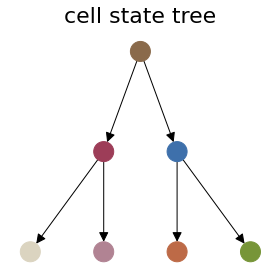

In [6]:
state_tree_draw(state_tree="((t1:2, t2:2):1, (t3:2, t4:2):1):2;", path=str(FIG_DIR))

And the actual simulated tree.<br>
For the purpose of visualizations we focus only the early tree (up to depth 8 in the simulation).

Only considering the two last: ['.4_12102', '.h5ad'].
Only considering the two last: ['.4_12102', '.h5ad'].


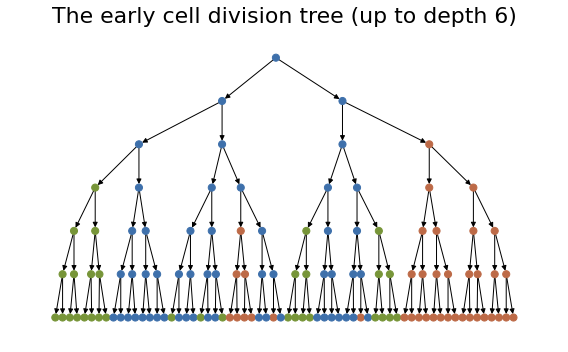

In [8]:
adata = sc.read(DATA_DIR / "adata_0.4_0.4_12102.h5ad")
tree_draw(adata, depth=6, path=str(FIG_DIR))

We can see that cell"s state obeys underlying cell state tree. <br>
For each cell the descendants are either of the same state or of a valid descendant based on the cell state tree.

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.umap(adata)

In [10]:
adata.uns["cluster_colors"] = [
    node_colors[c] for c in adata.obs["cluster"].cat.categories
]

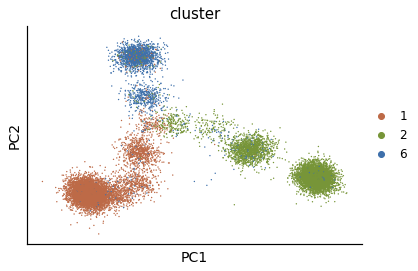

In [11]:
sc.pl.pca(adata[adata.obs["cluster"].isin([1, 2, 6])], color="cluster", show=False)
# plt.savefig(
#     FIG_DIR / "cluster_graph.png", bbox_inches="tight", transparent=True, dpi=300
# )
plt.show()

# Import grid search results

In [ ]:
filenames = glob.glob("/cs/labs/mornitzan/zoe.piran/research/projects/moslin_analysis_2/data/simulations/pan_tedsim/output/*.csv")

In [ ]:
filenames_mean = [file for file in filenames if "mean" in file]
filenames_mean

In [ ]:
res = None
for file in filenames_mean:
    fname = file.split("/")[-1].split("_")
    if len(fname) > 1:
        dfc = pd.read_csv(file)
        # for i in dfc.shape[0]:
        #     if row[1] > 0:
        #         ecost = row[14]
        #         lcost = row[15]
        #         mcost = (ecost + lcost)/2
        #         df_ = pd.DataFrame.from_dict({
        #             "p_a":[dfc.iloc[0, :]["p_a"]],
        #             "ss":[dfc.iloc[0, :]["ss"]],
        #             "config.data_seed":[row[3]],
        #             "config.alpha":[row[4]],
        #             "config.epsilon":[row[5]],
        #             "config.ssr":[row[6]],
        #             "config.tree_type":[row[7]],
        #             "config.seed":[row[11]], 
        #             "config.kind":[row[12]],
        #             "result.converged":[row[13]], 
        #             "result.early_cost":[ecost],
        #             "result.late_cost":[lcost],
        #             "result.mean_cost":[mcost]
        #         })
        if res is None:
            res = dfc
        else:
            res = pd.concat([res, dfc], ignore_index=True)

In [ ]:
res["converged"] = res["converged"].fillna(True)

In [ ]:
df = res.copy()

df = df[df["converged"] == True]

df["mean_cost"] = (
    df["early_cost"].astype(float) + df["late_cost"].astype(float)
) / 2


cols = [
    "p_a",
    "ssr",
    "ss",
    "kind",
    "alpha",
    "epsilon",
]

df_mean = df.groupby(cols).agg({"mean_cost": ["mean", "min", "std"]})
df_mean = df_mean.reset_index()
df_mean.columns = df_mean.columns.droplevel()
df_mean = df_mean.set_axis([*cols, "cost_mean", "cost_min", "cost_std"], axis=1)

idx = (
    df.groupby(
        ["p_a", "ssr", "ss", "kind", "data_seed"]
    )["mean_cost"].transform(min)
    == df["mean_cost"]
)

df_min = df[idx]


## Plot res

In [ ]:
p_a = 0.4
step_size = 0.4
df_min_ss = df_min[df_min["ss"] == step_size]
ssrs = np.sort(df_min_ss["ssr"].unique())
hue_order = ["LineageOT", "Cospar", "moslin"]
method_colors = {
    "moslin": "#E1BE6A",
    #"GW": "#117733",
    #"OT": "#88CCEE",
    "Cospar": "#A640B0",
    "LineageOT": "#40B0A6",
    # "Cospar": "#117733",
}

fontsize = 14

rows = 1
cols = len(ssrs)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

colors = {method: method_colors[method] for method in hue_order}
ax = sns.barplot(
    x="ssr",
    y="mean_cost",
    hue="kind",
    hue_order=hue_order,
    data=df_min_ss,
    ax=axs,
    palette=colors,
)

# plt.scatter(
#     x=[2.95, 3.95], #[2.75, 3.78],
#     y=[0.05, 0.05],
#     marker="*",
#     s=60,
#     label=".",
#     color=colors["Cospar"],
# )

# plt.scatter(
#     x=[2.7, 3.7], #[2.75, 3.78],
#     y=[0.05, 0.05],
#     marker="*",
#     s=60,
#     label="LineageOT\ntree-recon. fails",
#     color=colors["LineageOT"],
# )


ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("stochastic silencing rate")
ax.set_ylabel("mean cost", fontsize=fontsize)
ax.set_ylim(0, 1)
ax.legend(
    ncol=1,
    handlelength=1,
    fontsize=fontsize,
    # labelspacing=0.1,
    columnspacing=1,
    loc="upper right",
    bbox_to_anchor=(1.2, 0.2, 0.5, 0.5),
)
ax.tick_params(axis="both", which="both", length=0)

# plt.savefig(
#     # FIG_DIR / 
#     "ssr_ss0.4_pa0.4_cospar.pdf", bbox_inches="tight", dpi=300, format="pdf"
# )

plt.show()

# Import grid results

In [12]:
filenames = glob.glob("/cs/labs/mornitzan/zoe.piran/research/projects/moslin_analysis_2/data/simulations/pan_tedsim/output/*.csv")
filenames_cospar = [file for file in filenames if "cospar" in file]

In [13]:
res = None
for file in filenames_cospar:
    dfc = pd.read_csv(file)
    if "0.0_cospar" in file:
        continue
    if res is None:
        res = dfc
    else:
        res = pd.concat([res, dfc], ignore_index=True)

In [14]:
res["mean_cost"] = (res["early_cost"] + res["late_cost"]) / 2
res = res.drop(columns="Unnamed: 0")

In [15]:
res.loc[res["tree_type"] == "fitted-tree","kind"] = "Cospar (fitted-tree)"
res.loc[res["tree_type"] == "ground-truth","kind"] = "Cospar (ground-truth)"
res.loc[res["tree_type"] == "state-only","kind"] = "Cospar (state-only)"

In [16]:
res.to_csv(DATA_DIR / "tedsim_cospar.csv")

In [17]:
filenames = glob.glob("/cs/labs/mornitzan/zoe.piran/research/projects/moslin_analysis_2/data/simulations/pan_tedsim/output/*.csv")
filenames_moslin = [file for file in filenames if "mean_moslin" in file]

In [18]:
res_ms = None
for file in filenames_moslin:
    dfc = pd.read_csv(file)
    if res_ms is None:
        res_ms = dfc
    else:
        res_ms = pd.concat([res_ms, dfc], ignore_index=True)

In [19]:
res_ms["mean_cost"] = (res_ms["early_cost"] + res_ms["late_cost"]) / 2
res_ms = res_ms.drop(columns="Unnamed: 0")
res_ms.head()

,p_a,ss,ssr,data_seed,alpha,epsilon,scale_cost,depth,seed,kind,converged,early_cost,late_cost,tree_type,mean_cost
0,0.4,0.4,0.2,30139,0.0,0.0001,mean,10,619166398,moslin,False,0.697212,0.685355,bc,0.691284
1,0.4,0.4,0.2,30139,0.0,0.0010,mean,10,619166398,moslin,False,0.710818,0.686906,bc,0.698862
2,0.4,0.4,0.2,30139,0.0,0.0100,mean,10,619166398,moslin,True,0.717066,0.674795,bc,0.695930
3,0.4,0.4,0.2,30139,0.0,0.1000,mean,10,619166398,moslin,True,0.776650,0.730791,bc,0.753721
4,0.4,0.4,0.2,30139,0.1,0.0001,mean,10,619166398,moslin,False,0.688359,0.683113,bc,0.685736


In [20]:
res_ms.loc[res_ms["tree_type"] == "gt","kind"] = "moslin (ground-truth)"
res_ms.loc[res_ms["alpha"] == 0.0, "kind"] = "OT"
res_ms.loc[res_ms["alpha"] == 1.0, "kind"] = "GW"

In [22]:
res_ms.to_csv(DATA_DIR / "tedsim_moslin.csv")

In [23]:
df = pd.read_csv(DATA_DIR / "tedsim_lot.csv")

In [24]:
df["config.kind"] = df["config.kind"].replace(
    ["moscot", "lot"], ["moslin", "LineageOT"]
)
df["config.ssr"] = df["config.ssr"].fillna(0)

df = df.drop(
    [
        "Unnamed: 0",
        "_id",
        "config.overwrite",
        "config.db_collection",
        "config.depth",
        "result.scale_cost",
        "result.depth",
        "result.rank",
        "result.tree_type",
        "result.p_a",
        "result.ss",
        "result.seed",
        "result.ssr",
        "result.kind",
        "result.data_seed",
        "result.seed",
        "result.epsilon",
        "result.alpha",
    ],
    axis=1,
)

df = df[df["result.converged"] == True]

df["result.mean_cost"] = (
    df["result.early_cost"].astype(float) + df["result.late_cost"].astype(float)
) / 2

cols = [
    "config.p_a",
    "config.ssr",
    "config.ss",
    "config.kind",
    "config.alpha",
    "config.epsilon",
]

df_mean = df.groupby(cols).agg({"result.mean_cost": ["mean", "min", "std"]})
df_mean = df_mean.reset_index()
df_mean.columns = df_mean.columns.droplevel()
df_mean = df_mean.set_axis([*cols, "cost_mean", "cost_min", "cost_std"], axis=1)

idx = (
    df.groupby(
        ["config.p_a", "config.ssr", "config.ss", "config.kind", "config.data_seed"]
    )["result.mean_cost"].transform(min)
    == df["result.mean_cost"]
)

df_min = df[idx]

In [25]:
df_min = df_min.rename(columns=lambda x: x.split(".")[1])

In [26]:
df_cospar = pd.read_csv(DATA_DIR / "tedsim_cospar.csv", index_col=0)
df_cospar = df_cospar.drop(columns=df_cospar.columns[~df_cospar.columns.isin(df_min.columns)])

In [27]:
df_moslin = pd.read_csv(DATA_DIR / "tedsim_moslin.csv")
df_moslin = df_moslin.drop(columns=df_moslin.columns[~df_moslin.columns.isin(df_min.columns)])

In [28]:
idx = (
    df_moslin.groupby(
        ["p_a", "ssr", "ss", "kind", "data_seed"]
    )["mean_cost"].transform(min)
    == df_moslin["mean_cost"]
)
df_moslin_min = df_moslin[idx]

In [29]:
df_min = pd.concat([df_min, df_cospar, df_moslin_min], ignore_index=True)

## Plot res

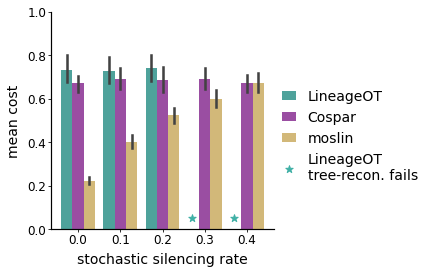

In [30]:
p_a = 0.4
step_size = 0.4
df_min_ss = df_min[df_min["ss"] == step_size]
ssrs = np.sort(df_min_ss["ssr"].unique())
hue_order = ["LineageOT", "Cospar", "moslin"]
method_colors = {
    "moslin": "#E1BE6A",
    "Cospar": "#A640B0",
    "LineageOT": "#40B0A6",
}

fontsize = 14

rows = 1
cols = len(ssrs)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

colors = {method: method_colors[method] for method in hue_order}
ax = sns.barplot(
    x="ssr",
    y="mean_cost",
    hue="kind",
    hue_order=hue_order,
    data=df_min_ss,
    ax=axs,
    palette=colors,
)


plt.scatter(
    x=[2.7, 3.7], #[2.75, 3.78],
    y=[0.05, 0.05],
    marker="*",
    s=60,
    label="LineageOT\ntree-recon. fails",
    color=colors["LineageOT"],
)


ax.set_xticklabels(ax.get_xticklabels())
ax.set_xlabel("stochastic silencing rate")
ax.set_ylabel("mean cost", fontsize=fontsize)
ax.set_ylim(0, 1)
ax.legend(
    ncol=1,
    handlelength=1,
    fontsize=fontsize,
    # labelspacing=0.1,
    columnspacing=1,
    loc="upper right",
    bbox_to_anchor=(1.2, 0.2, 0.5, 0.5),
)

plt.savefig(
    FIG_DIR / 
    "ssr_ss0.4_pa0.4_cospar.pdf", bbox_inches="tight", dpi=300, format="pdf"
)

plt.show()

In [31]:
df_min_stats = df_min_ss.drop(columns=['alpha', 'epsilon', 'p_a', 'ss', 'tree_type', 'seed', 'converged', 'early_cost', 'late_cost'])

In [32]:
mean_res = df_min_stats.groupby(["ssr", "kind"])["mean_cost"].mean()
std_res = df_min_stats.groupby(["ssr", "kind"])["mean_cost"].std()

In [33]:
pd.DataFrame(mean_res)

mean_cost
ssr kind                            
0.0 Cospar                  0.670427
    Cospar (fitted-tree)    0.670339
    Cospar (ground-truth)   0.670391
    Cospar (state-only)     0.670054
    GW                      0.243258
    LineageOT               0.733701
    OT                      0.740503
    moslin                  0.221521
    moslin (ground-truth)   0.746236
0.1 Cospar                  0.689923
    Cospar (fitted-tree)    0.688987
    GW                      0.451550
    LineageOT               0.728527
    OT                      0.703959
    moslin                  0.402050
0.2 Cospar                  0.686108
    Cospar (fitted-tree)    0.684147
    GW                      0.587782
    LineageOT               0.738780
    OT                      0.703959
    moslin                  0.522761
0.3 Cospar                  0.691004
    GW                      0.672890
    OT                      0.703959
    moslin                  0.600111
0.4 Cospar                  0.672893
    GW                      0.812456
    OT                      0.703959
    moslin                  0.672655

In [ ]:
mean_res_cmp[(mean_res_cmp["ssr"]==ssr) & (mean_res_cmp["kind"]=="moslin")]["mean_cost"].values[0]

In [34]:
mean_res_cmp = mean_res.reset_index()
mean_res_cmp["mean_diff"] = 0
for ssr in mean_res_cmp["ssr"].unique():
    mean_res_cmp.loc[mean_res_cmp["ssr"]==ssr ,"mean_diff"] = mean_res_cmp[mean_res_cmp["ssr"]==ssr]["mean_cost"].values - mean_res_cmp[(mean_res_cmp["ssr"]==ssr) & (mean_res_cmp["kind"]=="moslin")]["mean_cost"].values[0]
    

In [35]:
mean_res_cmp

,ssr,kind,mean_cost,mean_diff
0,0.0,Cospar,0.670427,0.448906
1,0.0,Cospar (fitted-tree),0.670339,0.448818
2,0.0,Cospar (ground-truth),0.670391,0.448870
3,0.0,Cospar (state-only),0.670054,0.448533
4,0.0,GW,0.243258,0.021737
5,0.0,LineageOT,0.733701,0.512180
6,0.0,OT,0.740503,0.518982
7,0.0,moslin,0.221521,0.000000
8,0.0,moslin (ground-truth),0.746236,0.524714
9,0.1,Cospar,0.689923,0.287873


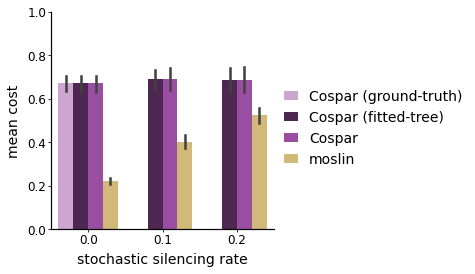

In [36]:
p_a = 0.4
step_size = 0.4
df_min_ss = df_min[df_min["ss"] == step_size]
df_min_ss = df_min_ss[df_min_ss["ssr"].isin([0. , 0.1, 0.2])]
ssrs = np.sort(df_min_ss["ssr"].unique())
hue_order = [ 'Cospar (ground-truth)','Cospar (fitted-tree)','Cospar', 'moslin']
method_colors = {
    "moslin": "#E1BE6A",
    "LineageOT": "#40B0A6",
    "Cospar": "#A640B0",
    "Cospar (fitted-tree)": "#532058",
    "Cospar (state-only)": "#d29fd7",
    "Cospar (ground-truth)": "#d29fd7" #"#311334",
}

fontsize = 14

rows = 1
cols = len(ssrs)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

colors = {method: method_colors[method] for method in hue_order}
ax = sns.barplot(
    x="ssr",
    y="mean_cost",
    hue="kind",
    hue_order=hue_order,
    data=df_min_ss,
    ax=axs,
    palette=colors,
)


ax.set_xticklabels(ax.get_xticklabels()) 
ax.set_xlabel("stochastic silencing rate")
ax.set_ylabel("mean cost", fontsize=fontsize)
ax.set_ylim(0, 1)
ax.legend(
    ncol=1,
    handlelength=1,
    fontsize=fontsize,
    # labelspacing=0.1,
    columnspacing=1,
    loc="upper right",
    bbox_to_anchor=(1.4, 0.2, 0.5, 0.5),
)

plt.savefig(
    FIG_DIR / 
    "ssr_ss0.4_pa0.4_cospar_supp.pdf", bbox_inches="tight", dpi=300, format="pdf"
)

plt.show()

# References


[[PHX-22] Pan, X., Li, H., & Zhang, X. (2022). TedSim: temporal dynamics simulation of single-cell RNA sequencing data and cell division history. Nucleic Acids Research, 50(8), 4272-4288.](https://doi.org/10.1093/nar/gkac235)